# Generating pokemon names with recurrent neural networks

This was a fun project indended to demosntrate the use of recurrent neural networks to generate text - in this case pokemon names. The basis of this is an assignment I had to complete as a requirememnt of the Course 'Intoduction to Deep Learning' by HSE on coursera.

The recurrent is trained using a corpus of around 800 pokemon names(smaller than whT one would like to have).
THe network is trained to predict the most probable next charecter based on some starting charecter.



In [62]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils

1.13.1


# Load data
The dataset contains ~800 pokemon names


In [63]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding when training the network

pad_token = "#"

with open("pokemons.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [64]:
print('number of samples:', len(names))
for x in names[::200]:
    print(x)

number of samples: 719
 Bulbasaur
 Unown
 Kricketot
 Klinklang


max length: 12


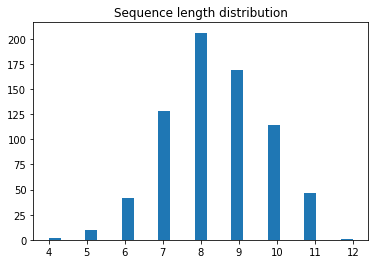

In [65]:
#EDA on pokemon names

MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);


# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [66]:
tokens = list(set(''.join(names)))

tokens.append("#")

n_tokens = len(tokens)
print ('n_tokens:', n_tokens)


n_tokens: 61


### Cast everything from symbols into identifiers


In [67]:
token_to_id = dict(zip( tokens ,range(n_tokens) ))

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [68]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [69]:
# Testing the to_matrix fun
print('\n'.join(names[::100]))
print(to_matrix(names[::100]))

 Bulbasaur
 Electrode
 Unown
 Delcatty
 Kricketot
 Oshawott
 Klinklang
 Hawlucha
[[49 44  4 15 42 24 58 24  4 36]
 [49  7 15 57 47  0 36 53 18 57]
 [49 45  3 53 48  3 60 60 60 60]
 [49 27 57 15 47 24  0  0 17 60]
 [49 13 36 21 47 40 57  0 53  0]
 [49 51 58 16 24 48 53  0  0 60]
 [49 13 15 21  3 40 15 24  3  9]
 [49  1 24 48 15  4 47 16 24 60]]


# Defining a recurrent neural network

The neral network we are going to built consists of - 

1. An embedding layer to lean charecter embeddings along with the model
2. A dense layer - the real deal - consisting of 64 neurons which take the present input as well as the present state of the network to generate next state
3. An output layer which generates a probability distribution for the next character from the hidden networks state

In [70]:

s = tf.Session()

In [71]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(units=64 , activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(units=61 , activation='softmax')


We will generate names character by character starting with `start_token`:

<img src="./char-nn.png" width=600>

In [72]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.

    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb,h_t])
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

# RNN: loop




In [73]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

# RNN: loss and gradients



In [74]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [75]:
# Define the loss as categorical cross-entropy 
loss = tf.reduce_mean(keras.losses.categorical_crossentropy(answers_matrix, predictions_matrix))

optimize = tf.train.AdamOptimizer().minimize(loss)

# RNN: training

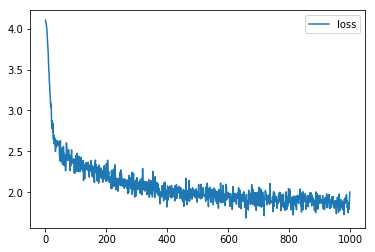

In [76]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [77]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  #update hidden state in this variable

next_probs, next_h = rnn_one_step(x_t, h_t)

In [78]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.

    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [79]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Crastiker
 Bowiko
 Mripuw
 Geawch
 Thoorme
 Minchatgron
 Baltaz
 Flerbiney
 Ralaxlund
 Biyzloa


In [80]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Bul'))

 Bultobil
 Bulimler
 Bullor
 Bulster
 Bulorlott
 Buledupt
 Bulruron
 Bulshiun
 Buliate
 Bulomiole
